In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 
os.environ['PYTHONHASHSEED'] = '0'
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from PIL import Image
from utils import * 

2023-08-18 09:56:00.881980: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


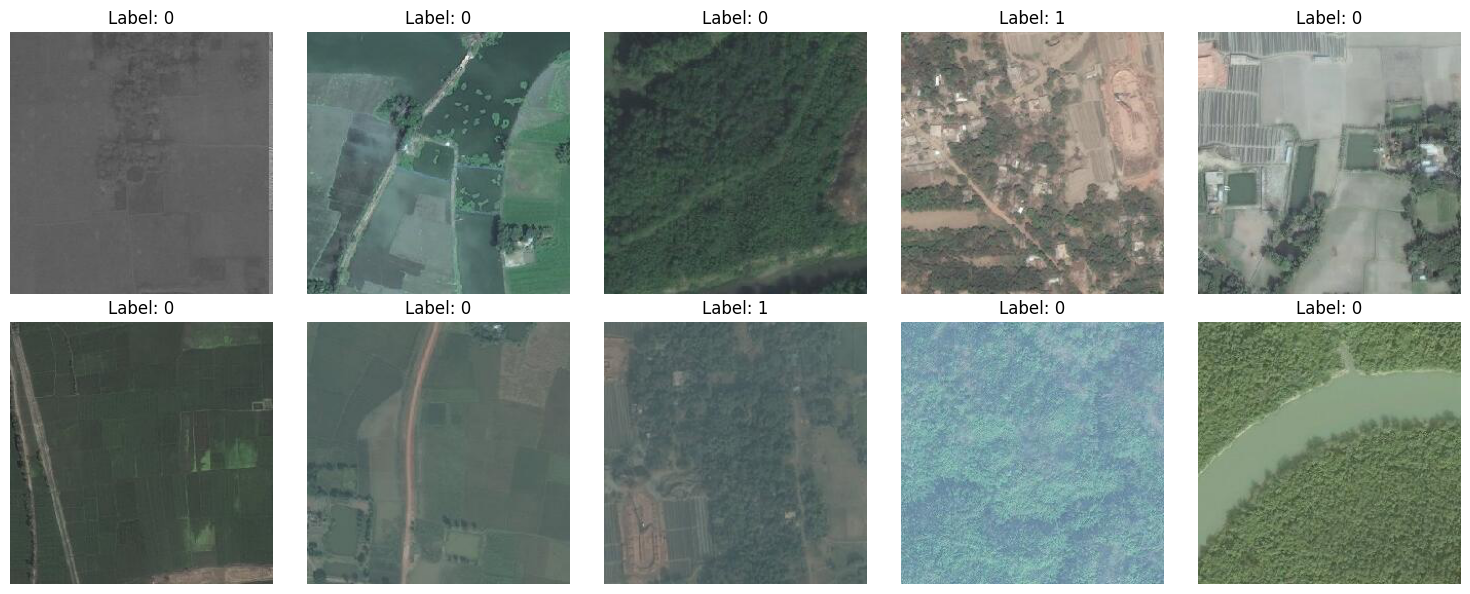

In [6]:
train_file_path = '/data/final_train.hdf5'
test_file_path = '/data/final_val.hdf5'

show_random_images_with_labels(train_file_path, num_images=10)

In [7]:
x_train, y_train = load_hdf5_data(train_file_path)
x_test, y_test = load_hdf5_data(test_file_path)

Images shape:  (2186, 256, 256, 3)
Labels shape:  (2186,)
Images shape:  (618, 256, 256, 3)
Labels shape:  (618,)


stratify train val split

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

class_0_train_count = np.sum(y_train == 0)
class_1_train_count = np.sum(y_train == 1)

class_0_val_count = np.sum(y_val == 0)
class_1_val_count = np.sum(y_val == 1)

class_0_test_count = np.sum(y_test == 0)
class_1_test_count = np.sum(y_test == 1)

print('Total in training set:', len(y_train))
print("Class 0 in training set:", class_0_train_count)
print("Class 1 in training set:", class_1_train_count)
print('Total in validation set:', len(y_val))
print("Class 0 in validation set:", class_0_val_count)
print("Class 1 in validation set:", class_1_val_count)
print('Total in test set:', len(y_test))
print("Class 0 in test set:", class_0_test_count)
print("Class 1 in test set:", class_1_test_count)

Total in training set: 1748
Class 0 in training set: 1533
Class 1 in training set: 215
Total in validation set: 438
Class 0 in validation set: 384
Class 1 in validation set: 54
Total in test set: 618
Class 0 in test set: 545
Class 1 in test set: 73


Converting images from (256, 256, 3) to (224, 224, 3) before passing to models

In [9]:
x_train = imgs_input_fn(x_train)
x_val = imgs_input_fn(x_val)
x_test = imgs_input_fn(x_test)
x_train.shape, x_val.shape, x_test.shape

2023-08-18 09:56:30.216167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78808 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


(TensorShape([1748, 224, 224, 3]),
 TensorShape([438, 224, 224, 3]),
 TensorShape([618, 224, 224, 3]))

Loading Indian data : Contains:
- label 0 No Brick kilns imgs  2000 of shape (256, 256, 3) 
- label 1 Brick kilns imgs 762 of shape (256, 256, 3) 

Total 2762 images which are converted to (224, 224, 3).

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith(".jpg") or img_path.endswith(".png"):
            image = Image.open(img_path).convert('RGB')            
            image = np.array(image)
            images.append(image)
    return images

folder_path_label_0 = '/data/Indian_dataset/label_0'
folder_path_label_1 = '/data/Indian_dataset/label_1'

label0_images = load_images_from_folder(folder_path_label_0)
label1_images = load_images_from_folder(folder_path_label_1)


# Assign labels to images
label0_labels = np.zeros(len(label0_images))
label1_labels = np.ones(len(label1_images))

# Merge images and labels
all_images = np.concatenate((label0_images, label1_images), axis=0)
all_labels = np.concatenate((label0_labels, label1_labels), axis=0)

# Shuffle the data (optional, but recommended)
indices = np.arange(len(all_images))
np.random.shuffle(indices)
all_images = all_images[indices]
all_labels = all_labels[indices]

# Save to HDF5 file
with h5py.File('Indian_dataset.h5', 'w') as f:
    f.create_dataset('image', data=all_images) 
    f.create_dataset('label', data=all_labels)

In [10]:
brick_kilns_india_path = '/data/Indian_dataset.h5'
images_ind, labels_ind = load_hdf5_data(brick_kilns_india_path)

Images shape:  (2762, 256, 256, 3)
Labels shape:  (2762,)


In [11]:
# we do split in indian data here to keep Indian test data same for all experiments.
images_train, images, labels_train, labels = train_test_split(images_ind, labels_ind, test_size=0.2, random_state=0, stratify=labels_ind)
images = imgs_input_fn(images) # Converting images from (256, 256, 3) to (224, 224, 3) before passing to models
images.shape

TensorShape([553, 224, 224, 3])

# Densenet

In [10]:
model_densenet = densenet_model(learning_rate=0.00002)
model_densenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [11]:
num_epochs = 100 # best epoch: 24.

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model_densenet.fit(x_train, y_train, batch_size=128, epochs=num_epochs, verbose=1, 
                       validation_data=(x_val, y_val),shuffle=False, callbacks=[early_stopping])
# Evaluate the model
train_loss, train_acc = model_densenet.evaluate(x_train, y_train)
test_loss, test_acc = model_densenet.evaluate(x_test, y_test)
print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc) 

Epoch 1/100


2023-08-14 23:15:15.020573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8903
2023-08-14 23:15:17.259796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-14 23:15:17.294035: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f0948f91760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-14 23:15:17.294078: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-08-14 23:15:17.300323: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-14 23:15:17.449257: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

14/14 [==============================] - 73s 841ms/step - loss: 0.5144 - acc: 0.7574 - val_loss: 0.4398 - val_acc: 0.8699
Epoch 2/100
14/14 [==============================] - 4s 293ms/step - loss: 0.2412 - acc: 0.9336 - val_loss: 0.3476 - val_acc: 0.9110
Epoch 3/100
14/14 [==============================] - 4s 289ms/step - loss: 0.1489 - acc: 0.9634 - val_loss: 0.2911 - val_acc: 0.9201
Epoch 4/100
14/14 [==============================] - 4s 284ms/step - loss: 0.1003 - acc: 0.9783 - val_loss: 0.2539 - val_acc: 0.9269
Epoch 5/100
14/14 [==============================] - 4s 274ms/step - loss: 0.0739 - acc: 0.9908 - val_loss: 0.2293 - val_acc: 0.9361
Epoch 6/100
14/14 [==============================] - 4s 291ms/step - loss: 0.0551 - acc: 0.9960 - val_loss: 0.2081 - val_acc: 0.9338
Epoch 7/100
14/14 [==============================] - 4s 273ms/step - loss: 0.0436 - acc: 0.9971 - val_loss: 0.1922 - val_acc: 0.9429
Epoch 8/100
14/14 [==============================] - 4s 284ms/step - loss: 0.033

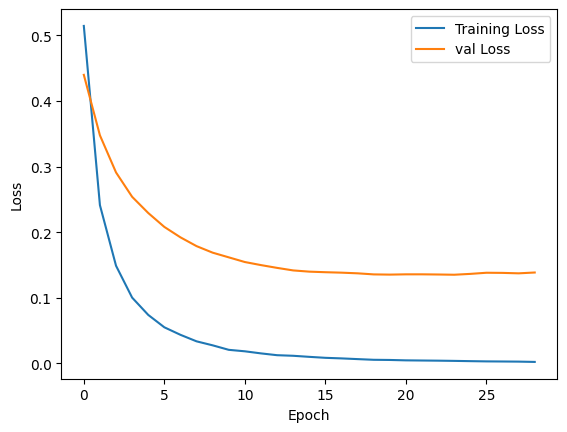

In [12]:
# Show loss vs. epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Prediction on bangladesh test

20/20 [==============================] - 2s 20ms/step


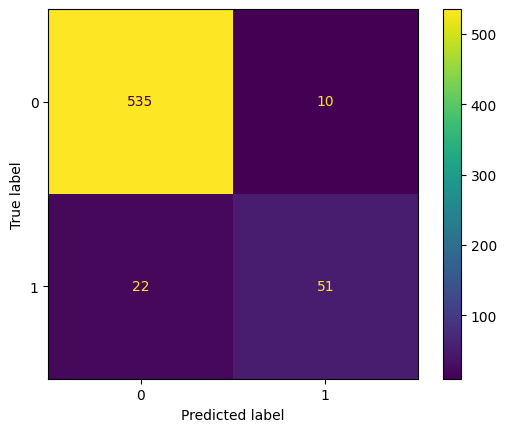

Precision:  0.8360655737704918
Recall:  0.6986301369863014
F1 score:  0.7611940298507464


In [15]:
y_pred_prob = model_densenet.predict(x_test)
y_pred_labels = np.round(y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()
precision = precision_score(y_test, y_pred_labels)
print("Precision: ", precision)
recall = recall_score(y_test, y_pred_labels)
print("Recall: ", recall)
f1 = f1_score(y_test, y_pred_labels)
print("F1 score: ", f1)

Prediction on indian test

In [16]:
test_loss, test_acc = model_densenet.evaluate(images, labels)
print(test_acc)

18/18 [==============================] - 2s 28ms/step - loss: 0.3639 - acc: 0.8409
0.8408679962158203


13/18 [====================>.........] - ETA: 0s

18/18 [==============================] - 0s 19ms/step


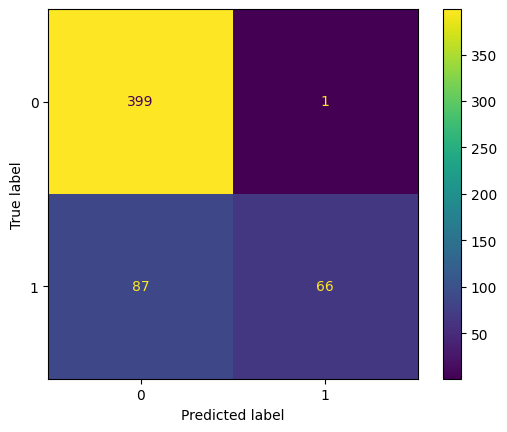

Precision:  0.9850746268656716
Recall:  0.43137254901960786
F1 score:  0.6


In [17]:
y_pred_prob = model_densenet.predict(images)
y_pred_labels = np.round(y_pred_prob)
conf_matrix = confusion_matrix(labels, y_pred_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()
precision = precision_score(labels, y_pred_labels)
print("Precision: ", precision)
recall = recall_score(labels, y_pred_labels)
print("Recall: ", recall)
f1 = f1_score(labels, y_pred_labels)
print("F1 score: ", f1)

# VGG

In [18]:
model_vgg = VGG_16_transfer_model_author(learning_rate=0.00002)
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 512)        0         
 ooling2D)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                      

In [19]:
num_epochs = 100 # best epoch: 4.

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model_vgg.fit(x_train, y_train, batch_size=128, epochs=num_epochs, verbose=1, 
                     validation_data=(x_val, y_val),shuffle=False, callbacks=[early_stopping])
# Evaluate the model 
train_loss, train_acc = model_vgg.evaluate(x_train, y_train)
test_loss, test_acc = model_vgg.evaluate(x_test, y_test)
print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)


Epoch 1/100


14/14 [==============================] - 29s 1s/step - loss: 0.3673 - acc: 0.8804 - val_loss: 0.2109 - val_acc: 0.9269
Epoch 2/100
14/14 [==============================] - 6s 418ms/step - loss: 0.2176 - acc: 0.9199 - val_loss: 0.1752 - val_acc: 0.9429
Epoch 3/100
14/14 [==============================] - 4s 257ms/step - loss: 0.1618 - acc: 0.9422 - val_loss: 0.1663 - val_acc: 0.9429
Epoch 4/100
14/14 [==============================] - 4s 254ms/step - loss: 0.1017 - acc: 0.9611 - val_loss: 0.1412 - val_acc: 0.9543
Epoch 5/100
14/14 [==============================] - 3s 247ms/step - loss: 0.1043 - acc: 0.9657 - val_loss: 0.2059 - val_acc: 0.9315
Epoch 6/100
14/14 [==============================] - 3s 228ms/step - loss: 0.0635 - acc: 0.9788 - val_loss: 0.1628 - val_acc: 0.9635
Epoch 7/100
14/14 [==============================] - 3s 236ms/step - loss: 0.0330 - acc: 0.9908 - val_loss: 0.2127 - val_acc: 0.9498
Epoch 8/100
14/14 [==============================] - 3s 232ms/step - loss: 0.0264 -

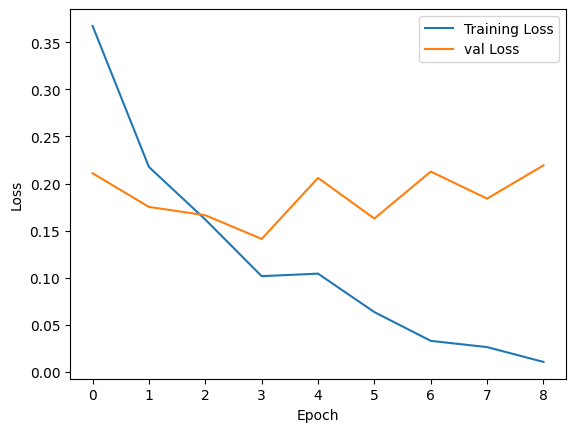

In [20]:
# Show loss vs. epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Prediction on bangladesh test

20/20 [==============================] - 1s 19ms/step


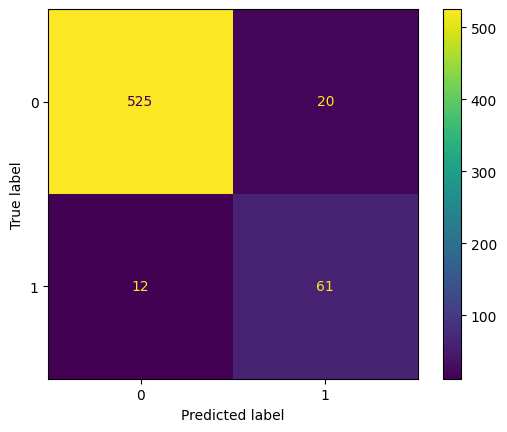

Precision:  0.7530864197530864
Recall:  0.8356164383561644
F1 score:  0.7922077922077922


In [23]:
y_pred_prob = model_vgg.predict(x_test)
y_pred_labels = np.round(y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()
precision = precision_score(y_test, y_pred_labels)
print("Precision: ", precision)
recall = recall_score(y_test, y_pred_labels)
print("Recall: ", recall)
f1 = f1_score(y_test, y_pred_labels)
print("F1 score: ", f1)

predict Indian test dataset

In [24]:
test_loss, test_acc = model_vgg.evaluate(images, labels)
print(test_acc)

18/18 [==============================] - 1s 38ms/step - loss: 0.3311 - acc: 0.8933
0.8933092355728149


 1/18 [>.............................] - ETA: 0s

18/18 [==============================] - 0s 19ms/step


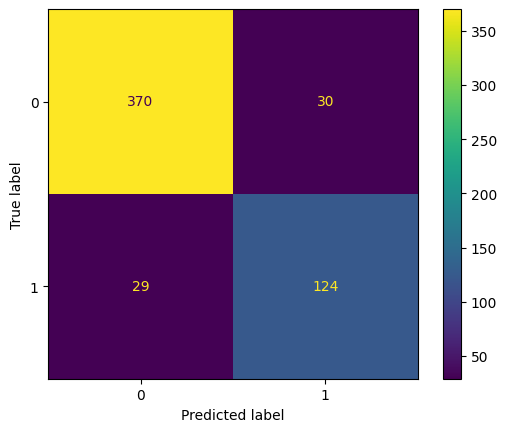

Precision:  0.8051948051948052
Recall:  0.8104575163398693
F1 score:  0.8078175895765473


In [25]:
y_pred_prob = model_vgg.predict(images)
y_pred_labels = np.round(y_pred_prob)
conf_matrix = confusion_matrix(labels, y_pred_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()
precision = precision_score(labels, y_pred_labels)
print("Precision: ", precision)
recall = recall_score(labels, y_pred_labels)
print("Recall: ", recall)
f1 = f1_score(labels, y_pred_labels)
print("F1 score: ", f1)

# Resnet

In [26]:
model_resnet = resnet_model(learning_rate=0.00002)
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 average_pooling2d_1 (Averag  (None, 1, 1, 2048)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 2049      
                                                      

In [27]:
num_epochs =  100 # best epoch: 30.

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model_resnet.fit(x_train, y_train, batch_size=128, epochs=num_epochs, verbose=1, 
                     validation_data=(x_val, y_val),   callbacks=[early_stopping])
# Evaluate the model 
train_loss, train_acc = model_resnet.evaluate(x_train, y_train)
test_loss, test_acc = model_resnet.evaluate(x_test, y_test)
print('Train accuracy: ', train_acc) 
print('Test accuracy: ', test_acc) 

Epoch 1/100


14/14 [==============================] - 42s 532ms/step - loss: 0.4254 - acc: 0.8438 - val_loss: 0.3611 - val_acc: 0.8767
Epoch 2/100
14/14 [==============================] - 3s 222ms/step - loss: 0.1996 - acc: 0.9205 - val_loss: 0.2731 - val_acc: 0.8858
Epoch 3/100
14/14 [==============================] - 3s 213ms/step - loss: 0.1107 - acc: 0.9577 - val_loss: 0.2892 - val_acc: 0.8927
Epoch 4/100
14/14 [==============================] - 3s 225ms/step - loss: 0.0600 - acc: 0.9874 - val_loss: 0.2504 - val_acc: 0.9201
Epoch 5/100
14/14 [==============================] - 3s 209ms/step - loss: 0.0321 - acc: 0.9971 - val_loss: 0.2800 - val_acc: 0.9247
Epoch 6/100
14/14 [==============================] - 3s 210ms/step - loss: 0.0172 - acc: 0.9989 - val_loss: 0.2533 - val_acc: 0.9292
Epoch 7/100
14/14 [==============================] - 3s 200ms/step - loss: 0.0107 - acc: 1.0000 - val_loss: 0.2479 - val_acc: 0.9338
Epoch 8/100
14/14 [==============================] - 3s 204ms/step - loss: 0.007

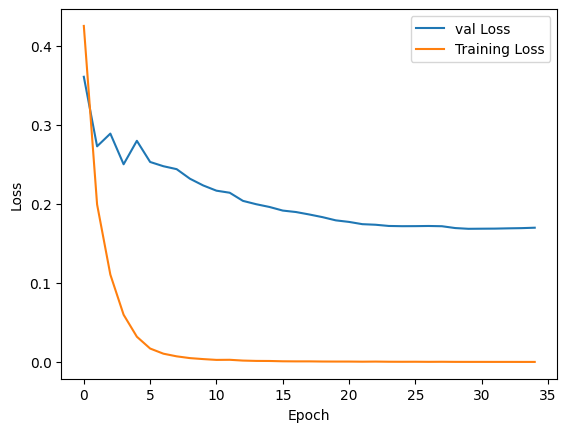

In [28]:
# Show loss vs. epochs 0.9498381614685059 loss: 0.0084 - acc: 0.9994 - val_loss: 0.1998 - val_acc: 0.9361 9
plt.plot(history.history['val_loss'], label='val Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Prediction on bangladesh test

20/20 [==============================] - 1s 16ms/step


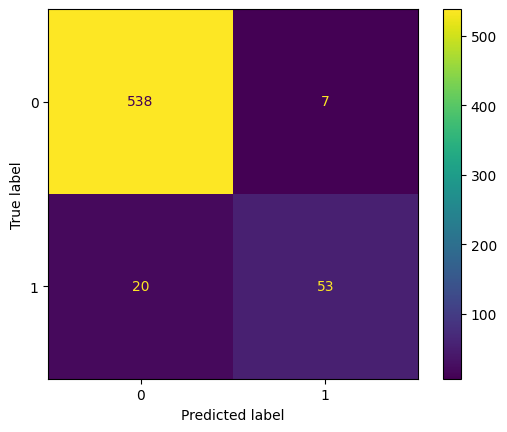

Precision:  0.8833333333333333
Recall:  0.726027397260274
F1 score:  0.7969924812030076


In [31]:
y_pred_prob = model_resnet.predict(x_test) 
y_pred_labels = np.round(y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()
precision = precision_score(y_test, y_pred_labels)
print("Precision: ", precision) 
recall = recall_score(y_test, y_pred_labels)
print("Recall: ", recall)
f1 = f1_score(y_test, y_pred_labels)
print("F1 score: ", f1) # 0.7794117647058825

predict on indian test dataset

In [32]:
test_loss, test_acc = model_resnet.evaluate(images, labels) # 0.7703436017036438
print(test_acc)

18/18 [==============================] - 1s 27ms/step - loss: 0.4156 - acc: 0.8626
0.8625677824020386


18/18 [==============================] - 0s 15ms/step


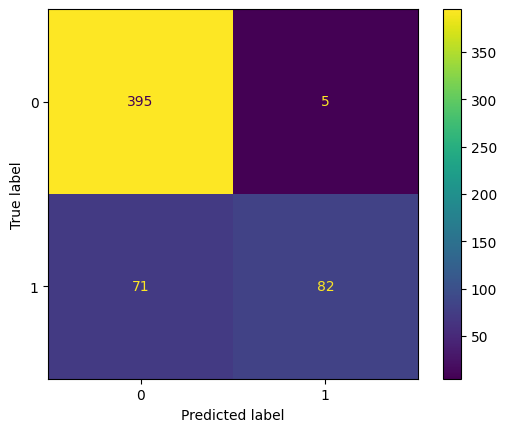

Precision:  0.9425287356321839
Recall:  0.5359477124183006
F1 score:  0.6833333333333333


In [33]:
y_pred_prob = model_resnet.predict(images)
y_pred_labels = np.round(y_pred_prob)
conf_matrix = confusion_matrix(labels, y_pred_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()
precision = precision_score(labels, y_pred_labels)
print("Precision: ", precision)
recall = recall_score(labels, y_pred_labels)
print("Recall: ", recall)
f1 = f1_score(labels, y_pred_labels)
print("F1 score: ", f1) # 0.29050279329608936 0.6833333333333333

# EfficientNetB0

In [34]:
model_efficientnetb0 = efficientnet_b0_model(learning_rate=0.00002)
model_efficientnetb0.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                      

In [35]:
num_epochs = 100 # best epoch: 40.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model_efficientnetb0.fit(x_train, y_train, batch_size=128, epochs=num_epochs, verbose=1, 
                     callbacks=[early_stopping], validation_data=(x_val, y_val))
# Evaluate the model
train_loss, train_acc = model_efficientnetb0.evaluate(x_train, y_train)
test_loss, test_acc = model_efficientnetb0.evaluate(x_test, y_test)
print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc) 

Epoch 1/100


2023-08-14 23:22:06.343139: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


14/14 [==============================] - 41s 362ms/step - loss: 0.7118 - acc: 0.4903 - val_loss: 0.7968 - val_acc: 0.2900
Epoch 2/100
14/14 [==============================] - 4s 271ms/step - loss: 0.5768 - acc: 0.7351 - val_loss: 0.7243 - val_acc: 0.4680
Epoch 3/100
14/14 [==============================] - 4s 269ms/step - loss: 0.4836 - acc: 0.8238 - val_loss: 0.6381 - val_acc: 0.6393
Epoch 4/100
14/14 [==============================] - 4s 267ms/step - loss: 0.4162 - acc: 0.8759 - val_loss: 0.5470 - val_acc: 0.7534
Epoch 5/100
14/14 [==============================] - 4s 269ms/step - loss: 0.3488 - acc: 0.9079 - val_loss: 0.4576 - val_acc: 0.8493
Epoch 6/100
14/14 [==============================] - 4s 260ms/step - loss: 0.2945 - acc: 0.9233 - val_loss: 0.3834 - val_acc: 0.8995
Epoch 7/100
14/14 [==============================] - 4s 257ms/step - loss: 0.2556 - acc: 0.9394 - val_loss: 0.3269 - val_acc: 0.9155
Epoch 8/100
14/14 [==============================] - 4s 262ms/step - loss: 0.222

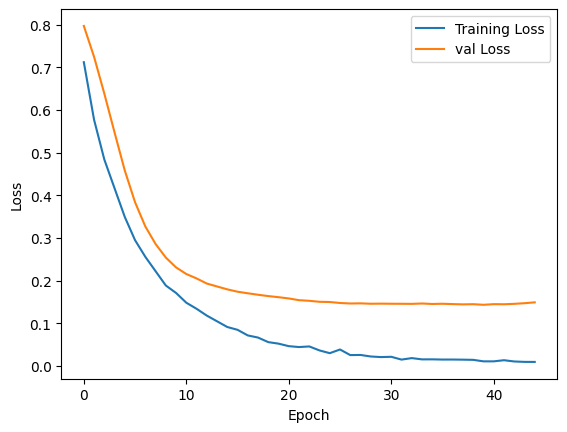

In [38]:
# Show loss vs. epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Prediction on bangladesh test

20/20 [==============================] - 1s 15ms/step


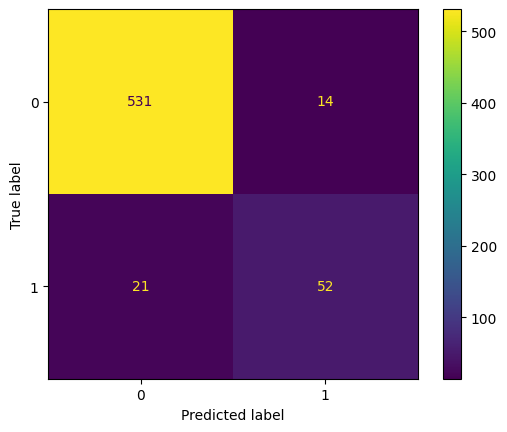

Precision:  0.7878787878787878
Recall:  0.7123287671232876
F1 score:  0.7482014388489209


In [41]:
y_pred_prob = model_efficientnetb0.predict(x_test)
y_pred_labels = np.round(y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred_labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()
precision = precision_score(y_test, y_pred_labels)
print("Precision: ", precision)
recall = recall_score(y_test, y_pred_labels)
print("Recall: ", recall)
f1 = f1_score(y_test, y_pred_labels)
print("F1 score: ", f1)

Predict on indian data

In [42]:
test_loss, test_acc = model_efficientnetb0.evaluate(images, labels)
print(test_acc)

18/18 [==============================] - 1s 20ms/step - loss: 0.3430 - acc: 0.8698
0.8698011040687561


18/18 [==============================] - 0s 15ms/step


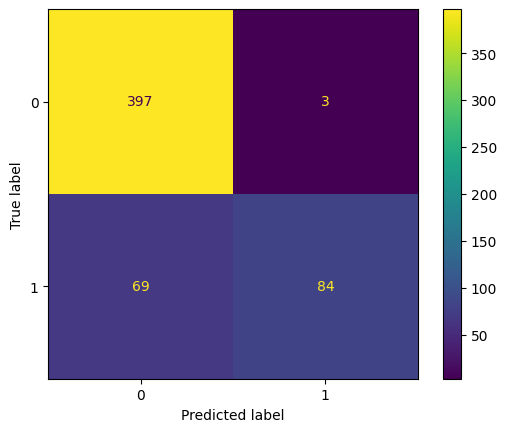

Precision:  0.9655172413793104
Recall:  0.5490196078431373
F1 score:  0.7000000000000002


In [45]:
y_pred_prob_indian = model_efficientnetb0.predict(images)
y_pred_labels_indian = np.round(y_pred_prob_indian)
conf_matrix = confusion_matrix(labels, y_pred_labels_indian)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['0', '1'])
cm_display.plot()
plt.show()
precision = precision_score(labels, y_pred_labels_indian)
print("Precision: ", precision)
recall = recall_score(labels, y_pred_labels_indian)
print("Recall: ", recall)
f1 = f1_score(labels, y_pred_labels_indian)
print("F1 score: ", f1)